# Problem Statement: 
An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

The company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone.

X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',50)
sn.set_theme(style="darkgrid")
plt.style.use('ggplot')

# Data Understanding

In [2]:
lead= pd.read_csv('Leads.csv')
lead.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
lead.shape

(9240, 37)

Dataset contains 9240 rows and 37 columns. Out of which we seeprospect ID and Lead Number can be treated as unique identifier for a particular customer. Hence will try to drop one of them. Converted will be the target variable. We can clearly see null values are present in teh dataset from the first 5 rows only, hence we need to deal with them. 

In [4]:
lead.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

There are many columns in the dataset havin large number of missing values. Some Data manipulation also needs to be done.

# Missing Values and Vague Values Detection

In [5]:
missing=round(((lead.isnull().sum())/lead.shape[0])*100,2)
missing= list(zip(lead.columns,missing))
colsmax= [x for x in missing if x[1]>15]
colsmax

[('Country', 26.63),
 ('Specialization', 15.56),
 ('How did you hear about X Education', 23.89),
 ('What is your current occupation', 29.11),
 ('What matters most to you in choosing a course', 29.32),
 ('Tags', 36.29),
 ('Lead Quality', 51.59),
 ('Lead Profile', 29.32),
 ('City', 15.37),
 ('Asymmetrique Activity Index', 45.65),
 ('Asymmetrique Profile Index', 45.65),
 ('Asymmetrique Activity Score', 45.65),
 ('Asymmetrique Profile Score', 45.65)]

Above columns have the hiighest number of missing values (>15%). Although if we look into the data dictioniary we can see vague entry 'Select' which also can be treated as null. Will update the 'Select' entries to nulls and then check again for nulls.

In [6]:
select= lead.apply(lambda x: x=='Select').sum()
select= list(zip(lead.columns, select))
select= [x for x in select if x[1]>0]
select

[('Specialization', 1942),
 ('How did you hear about X Education', 5043),
 ('Lead Profile', 4146),
 ('City', 2249)]

In [7]:
lead= lead.replace('Select',np.nan)

# Cross check
select= lead.apply(lambda x: x=='Select').sum()
select= list(zip(lead.columns, select))
select= [x for x in select if x[1]>0]
select

[]

In [8]:
# Checking Nulls again
missing=round(((lead.isnull().sum())/lead.shape[0])*100,2)
missing= list(zip(lead.columns,missing))
colsmax= [x for x in missing if x[1]>15]
colsmax

[('Country', 26.63),
 ('Specialization', 36.58),
 ('How did you hear about X Education', 78.46),
 ('What is your current occupation', 29.11),
 ('What matters most to you in choosing a course', 29.32),
 ('Tags', 36.29),
 ('Lead Quality', 51.59),
 ('Lead Profile', 74.19),
 ('City', 39.71),
 ('Asymmetrique Activity Index', 45.65),
 ('Asymmetrique Profile Index', 45.65),
 ('Asymmetrique Activity Score', 45.65),
 ('Asymmetrique Profile Score', 45.65)]

1. We have almost 13 columns having nulls greater than 15%. We'll need to check for the columns impact target variable- Converted, and will accordinly either drop the columns/rows or impute them.

2. ('Asymmetrique Activity Index', 45.65),
     ('Asymmetrique Profile Index', 45.65),
     ('Asymmetrique Activity Score', 45.65),
     ('Asymmetrique Profile Score', 45.65) have exactly same number of null values that means all of them are null at the same time for a particular customer, hence deleting those rows will reduce our dataset to a large extent , therefore we'll drop the columns itself.
     

In [9]:
lead[lead['Asymmetrique Activity Index'].isnull()].head()
lead.drop(columns= ['Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score'],inplace=True)

In [10]:
# Checking Nulls again
missing=round(((lead.isnull().sum())/lead.shape[0])*100,2)
missing= list(zip(lead.columns,missing))
colsmax= [x for x in missing if x[1]>15]
colsmax

[('Country', 26.63),
 ('Specialization', 36.58),
 ('How did you hear about X Education', 78.46),
 ('What is your current occupation', 29.11),
 ('What matters most to you in choosing a course', 29.32),
 ('Tags', 36.29),
 ('Lead Quality', 51.59),
 ('Lead Profile', 74.19),
 ('City', 39.71)]

Lead Quality, Lead Profile and 'How did you hear about X Education' still have very high percentage of missing values (>50%). Looking at the data it seems these features are not that important for predicting the conversion. Hence Will be dropping those.

In [11]:
lead.drop(columns= ['Lead Quality','Lead Profile','How did you hear about X Education'], inplace=True)

### City

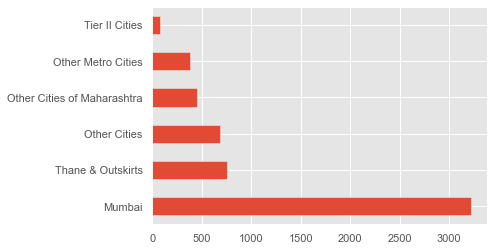

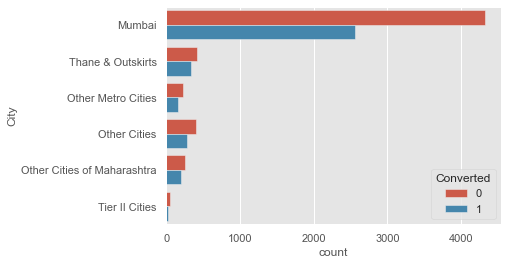

In [12]:
lead.City.value_counts().plot.barh()
plt.show()

# Mumbai is at par the highest number of records .We'll replace nulls with Mode- 'Mumbai'
# If Business involved we can consult with them as well.
# For now we'll keep the feature, if model prediction won't depend on city, we will drop it then

lead.City= lead.City.replace(np.nan, 'Mumbai')
sn.countplot(y=lead.City, hue=lead.Converted)
plt.show()

### Tags

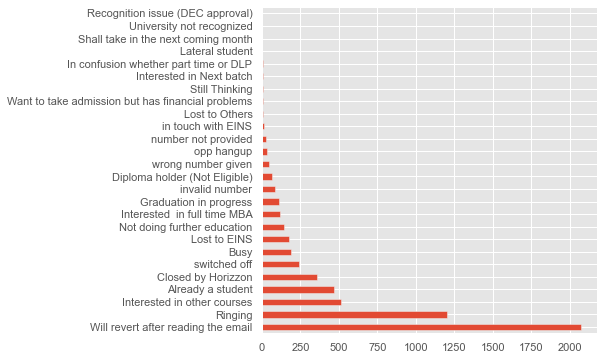

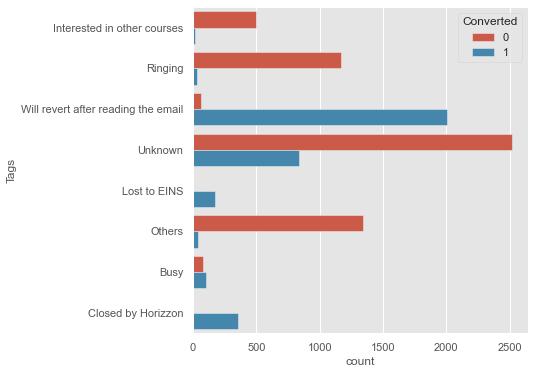

In [13]:
plt.figure(figsize=(6,6))
lead.Tags.value_counts().plot.barh()
plt.show()

# As 'Will revert after reading teh mail' (2000 approx) and 'Ringing'(1250) are not so far part, 
# replacing 36% null entries to mode may cause issue and can make the dataset bias. Hence best to create another subcategory as Unknown
# Also as there are many subcategories in Tags column we'll club them together
# We can drop the column  if model prediction will not depend on the feature.

lead.Tags= lead.Tags.replace(np.nan, 'Unknown')

#Binning of less frequent columns to others

l= ['Recognition issue (DEC approval)', 'University not recognized', 'Shall take in the next coming month', 'Lateral student', 
   'Interested in Next batch', 'In confusion whether part time or DLP', 'Still Thinking', 'Want to take admission but has financial problems',
   'Lost to Others', 'in touch with EINS', 'number not provided','opp hangup', 'wrong number given', 'Diploma holder (Not Eligible)','invalid number',
   'Already a student','switched off', 'Not doing further education', 'Interested  in full time MBA', 'Graduation in progress']
lead.Tags= lead.Tags.replace(l, 'Others')


# Target variable distribution
plt.figure(figsize=(6,6))
sn.countplot(y=lead.Tags, hue= lead.Converted)
plt.show()

'Will Revert after Reading the mail' have very very hih conversion rate, it can definitely be a influencing factor to predict if a customer will convert or not. Similar is the case of 'Lost to EINS' subcategory where non-converted are almost zero.

### What is your current occupation

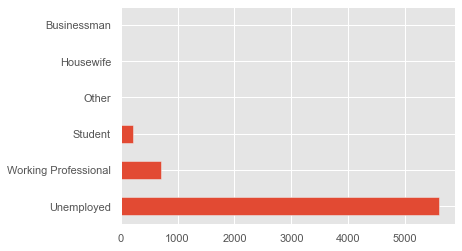

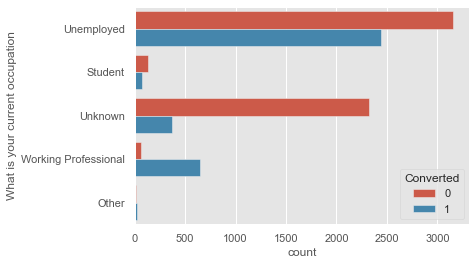

In [14]:
lead['What is your current occupation'].value_counts().plot.barh()
plt.show()

# Clearly 'Unemployed' is having 5k+ entries in teh dataset hence making a large difference with other subtypes.
# We can replace 29% of the null values to mode ie, Unemployed
# Also we can club Housewife and Businessman to Other as their count is very very low.

lead.loc[(lead['What is your current occupation'].isnull()), 'What is your current occupation']= 'Unknown'
lead['What is your current occupation']= lead['What is your current occupation'].replace(['Housewife', 'Businessman'], 'Other')

# Converted column distribution
sn.countplot(y=lead['What is your current occupation'], hue=lead.Converted)
plt.show()

### What matters most to you in choosing a course

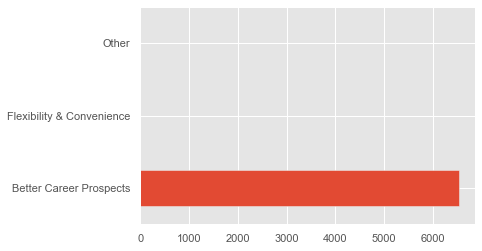

In [15]:
lead['What matters most to you in choosing a course'].value_counts().plot.barh()
plt.show()

# As there is no real variance in the column we can simply drop it.
lead.drop(columns= ['What matters most to you in choosing a course'], inplace=True)

### Specialization

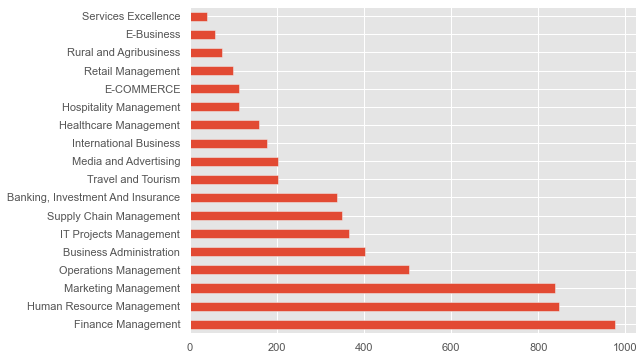

In [16]:
plt.figure(figsize= (8,6))
lead['Specialization'].value_counts().plot.barh()
plt.show()

# There is not much difference between HR and Finance Management subgroup and others as well. 
# HEnce imputing 36% (3000+)null values with the mode would be risky and may make the data bias. 
# Best choice is to drop the column itself. We can take that column again if model prediction depends on it. 

lead.drop(columns= ['Specialization'],inplace=True)

### Country

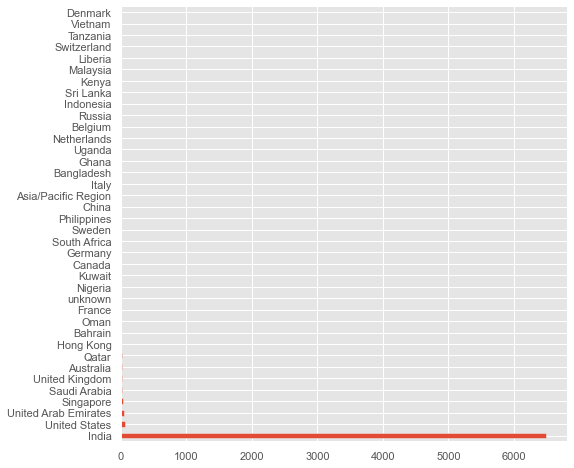

In [17]:
plt.figure(figsize= (8,8))
lead.Country.value_counts().plot.barh()
plt.show()

#India Clearly has the highest count of customers, hence iNdian people would be the best to target. 
# As their is not much variance in the columns we can simply drop it

lead.drop(columns= ['Country'], inplace=True)

### Lead Source

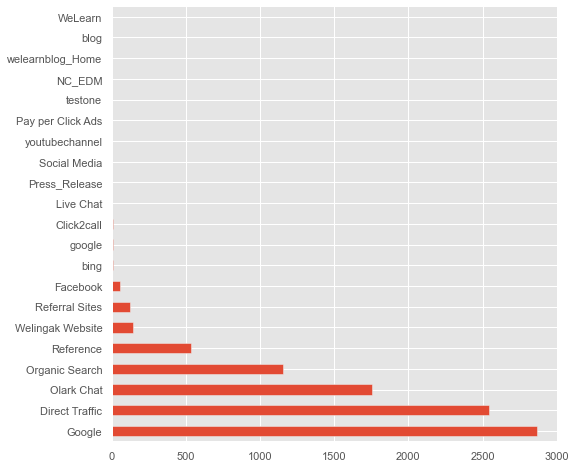

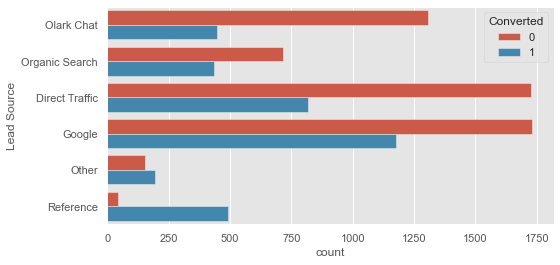

In [18]:
plt.figure(figsize= (8,8))
lead['Lead Source'].value_counts().plot.barh()
plt.show()
lead['Lead Source'].isnull().value_counts()

# We will impute 36 null values with mode- Google. as it won't make any differnce in the current count.
# Also we'll bin the lowest count subcategories into Other

lead.loc[lead['Lead Source'].isnull(), 'Lead Source']= 'Google'
lead['Lead Source']= lead['Lead Source'].replace('google', 'Google')
l= ['bing','Click2call', 'Press_Release', 'Social Media', 'Live Chat', 'blog', 'youtubechannel', 'welearnblog_Home', 'Pay per Click Ads',
    'NC_EDM','WeLearn', 'testone','Facebook', 'Referral Sites', 'Welingak Website']
lead['Lead Source']= lead['Lead Source'].replace(l, 'Other')

# Converted column distribution
plt.figure(figsize=(8,4))
sn.countplot(y=lead['Lead Source'],hue=lead.Converted)
plt.show()

1. Reference subcategory has the hihest conversion rate, hence compsny should provide more perks to the existing customers for providing references. Once received referenced cadidates, company should focus more on them.
2. Lead Source- Google and Direct Traffic also have high conversion rate, these should also be the one to be focused on.

### Page Views Per Visit

In [19]:
lead[(lead['Page Views Per Visit'].isnull())]

# Page Views Per Visit and Total visits have similar number if nulls ie, 1.48%. 
# From below dataset we can see both columns are giving nulls together for a customer. 
#Also these rows are not giving much of the inferences, therefore will be dropping the rows.
#HEnce best to drop the rows for both columns

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
77,895d4905-f534-4f18-915b-8d239a72b5dc,659722,Lead Add Form,Other,No,No,1,NaN,1096,NaN,NaN,Unemployed,No,No,No,No,No,No,No,No,Unknown,No,No,Mumbai,No,No,Modified
79,3a0ce10f-d2c1-4213-a2bc-4f97bcd29699,659710,Lead Add Form,Reference,No,No,1,NaN,705,NaN,NaN,Working Professional,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Thane & Outskirts,No,No,Modified
81,277ad6a6-4565-4a18-a1ff-e46e03f22663,659705,Lead Add Form,Other,No,No,1,NaN,346,NaN,NaN,Unemployed,No,No,No,No,No,No,No,No,Unknown,No,No,Mumbai,No,No,Modified
88,68f496c2-0073-470f-9c3c-7fb48f060ce5,659631,Lead Add Form,Reference,No,No,1,NaN,1007,NaN,NaN,Unemployed,No,No,No,No,No,No,No,No,Closed by Horizzon,No,No,Mumbai,No,No,Modified
120,144807db-2895-4002-b52e-3eda79c22395,659283,Lead Add Form,Reference,No,No,1,NaN,1111,NaN,NaN,Working Professional,No,No,No,No,No,No,No,No,Closed by Horizzon,No,No,Other Cities,No,No,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8097,82f3035c-0750-4f09-a0cc-4288abb88042,587973,Lead Add Form,Reference,No,No,0,NaN,1201,NaN,NaN,Unemployed,No,No,No,No,No,No,No,No,Others,No,No,Mumbai,No,No,Modified
8107,7e66be45-783c-4983-b4cd-c6594bbbeee8,587916,Lead Add Form,Reference,No,No,1,NaN,903,NaN,NaN,Working Professional,No,No,No,No,No,No,No,No,Lost to EINS,No,No,Mumbai,No,No,Modified
8434,f5be8a84-bfa2-46a6-816a-af81a45ea6b9,585438,Lead Add Form,Reference,No,No,1,NaN,1458,NaN,NaN,Unemployed,No,No,No,No,No,No,No,No,Closed by Horizzon,No,No,Mumbai,No,No,Modified
9015,5857eeef-41cb-4523-a654-8709f6c8d8c6,581257,Lead Add Form,Reference,No,No,1,NaN,1159,NaN,NaN,Working Professional,No,No,No,No,No,No,No,No,Closed by Horizzon,No,No,Mumbai,No,No,Modified


In [20]:
lead= lead[~(lead['Page Views Per Visit'].isnull())]

In [21]:
lead.isnull().sum()

Prospect ID                                 0
Lead Number                                 0
Lead Origin                                 0
Lead Source                                 0
Do Not Email                                0
Do Not Call                                 0
Converted                                   0
TotalVisits                                 0
Total Time Spent on Website                 0
Page Views Per Visit                        0
Last Activity                               0
What is your current occupation             0
Search                                      0
Magazine                                    0
Newspaper Article                           0
X Education Forums                          0
Newspaper                                   0
Digital Advertisement                       0
Through Recommendations                     0
Receive More Updates About Our Courses      0
Tags                                        0
Update me on Supply Chain Content 

### Lead Origin Distribution

<AxesSubplot:xlabel='count', ylabel='Lead Origin'>

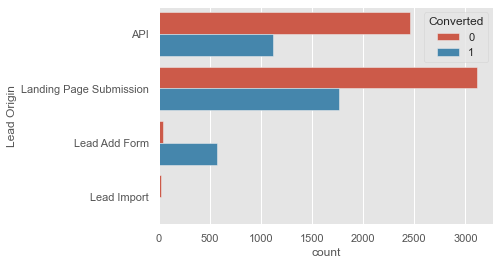

In [22]:
sn.countplot(y=lead['Lead Origin'], hue= lead['Converted'])

Lead Add Form has the highest conversion rate while Lead Import has least. Will remove this subcategory while dummy creation

# Data Cleaning and EDA

In [23]:
lead.shape

(9103, 27)

In [24]:
lead.dtypes

Prospect ID                                  object
Lead Number                                   int64
Lead Origin                                  object
Lead Source                                  object
Do Not Email                                 object
Do Not Call                                  object
Converted                                     int64
TotalVisits                                 float64
Total Time Spent on Website                   int64
Page Views Per Visit                        float64
Last Activity                                object
What is your current occupation              object
Search                                       object
Magazine                                     object
Newspaper Article                            object
X Education Forums                           object
Newspaper                                    object
Digital Advertisement                        object
Through Recommendations                      object
Receive More

In [25]:
# Duplicate check

lead.duplicated().sum()

0

In [26]:
# Since no duplicates in the dataset, we can drop columns- Prospect ID, Lead Number . We'll keep one to identify the customer later if required

lead.drop(columns= ['Lead Number'], inplace=True)

## Categorical Features Analysis

Prospect ID :-   (array(['7927b2df-8bba-4d29-b9a2-b6e0beafe620',
       '2a272436-5132-4136-86fa-dcc88c88f482',
       '8cc8c611-a219-4f35-ad23-fdfd2656bd8a', ...,
       'aac550fe-a586-452d-8d3c-f1b62c94e02c',
       '5330a7d1-2f2b-4df4-85d6-64ca2f6b95b9',
       '571b5c8e-a5b2-4d57-8574-f2ffb06fdeff'], dtype=object), 9103)

Lead Origin :-   (array(['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import'],
      dtype=object), 4)

Lead Source :-   (array(['Olark Chat', 'Organic Search', 'Direct Traffic', 'Google',
       'Other', 'Reference'], dtype=object), 6)

Do Not Email :-   (array(['No', 'Yes'], dtype=object), 2)

Do Not Call :-   (array(['No', 'Yes'], dtype=object), 2)

Last Activity :-   (array(['Page Visited on Website', 'Email Opened', 'Unreachable',
       'Converted to Lead', 'Olark Chat Conversation', 'Email Bounced',
       'Email Link Clicked', 'Form Submitted on Website', 'Unsubscribed',
       'Had a Phone Conversation', 'View in browser link Clicked',
      

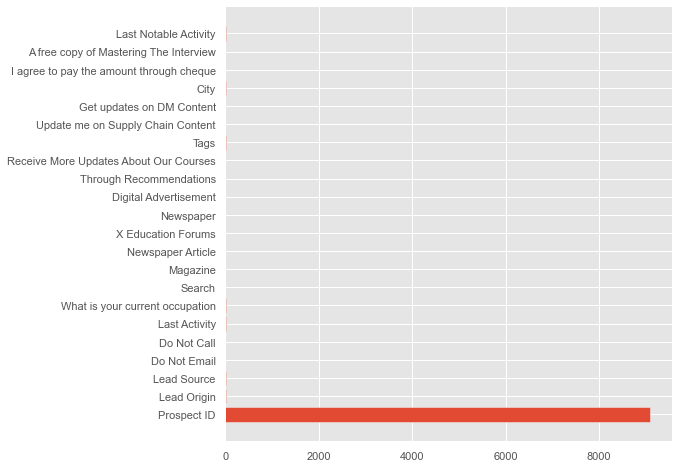

In [27]:
cols= lead.columns
d={}
l=[]
coll=[]
for i in cols:
        if lead[i].dtype=='object':
            d[i]= lead[i].unique(), lead[i].nunique()
            l.append(lead[i].nunique())
            coll.append(i)
            print(i, ':-  ', d[i])
            print()
    

plt.figure(figsize= (8,8))
plt.barh(y= coll, width=l)
plt.show()

1. we can see columns= Last Notable Activity , Last Activity have notably high number of subcategories, We'll check the individual distribution to see if any binning can be done.
2. Some columns are present with only one value ie,no - hence no variance present. Hence We will be dropping the same.follwing are the cols= Magazine, Receive More Updates About Our Courses, Update me on Supply Chain Content, Get updates on DM Content, 
      I agree to pay the amount through cheque


In [28]:
lead.drop(columns= ['Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque'],inplace=True)

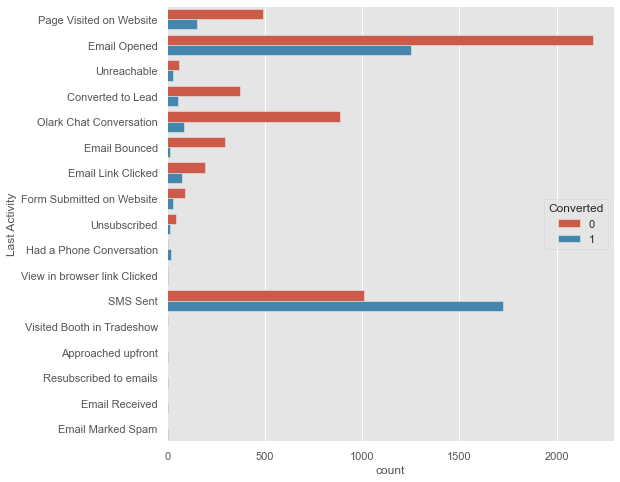

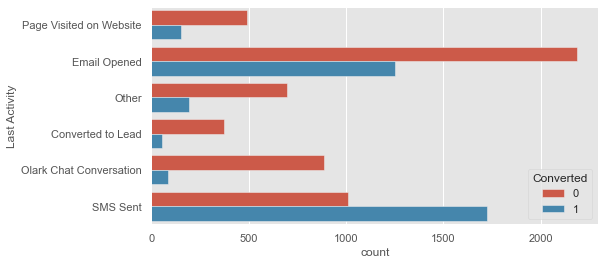

In [29]:
# Binning of Last Activity sub Categories
plt.figure(figsize=(8,8))
sn.countplot(y= lead['Last Activity'], hue= lead['Converted'], orient= "v")
plt.show()

l= ['Email Received', 'Resubscribed to emails', 'Visited Booth in Tradeshow', 'Email Marked Spam', 'Approached upfront', 'View in browser link Clicked',
    'Unsubscribed ', 'Converted to Lead ', 'Email Bounced', 'Had a Phone Conversation', 'Unsubscribed', 'Unreachable', 'Form Submitted on Website',
   'Email Link Clicked']
lead['Last Activity']= lead['Last Activity'].replace(l, 'Other')


# Converted column distribution
plt.figure(figsize=(8,4))
sn.countplot(y= lead['Last Activity'], hue= lead['Converted'], orient= "v")
plt.show()

SMS Sent and Email Opened has good converting rate , hence it can be a good predictor in order to increase conversions.

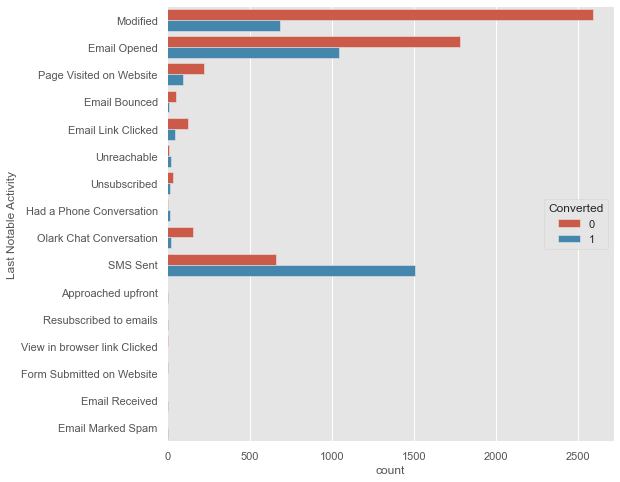

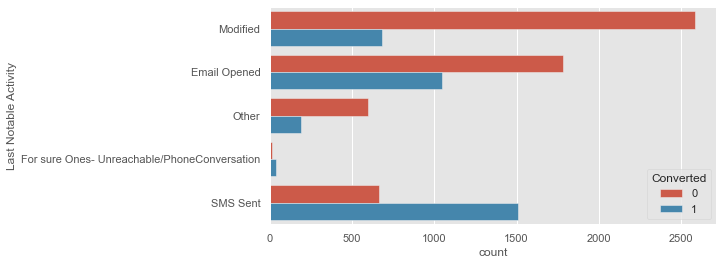

In [30]:
# Binning og Last Notable Activity sub Categories
plt.figure(figsize=(8,8))
sn.countplot(y= lead['Last Notable Activity'], hue= lead['Converted'], orient= "v")
plt.show()

lead['Last Notable Activity']= lead['Last Notable Activity'].replace(['Unreachable', 'Had a Phone Conversation'], 'For sure Ones- Unreachable/PhoneConversation')

l= ['Email Received', 'Resubscribed to emails',  'Email Marked Spam', 'Approached upfront', 'View in browser link Clicked',
    'Unsubscribed',  'Email Bounced',  'Form Submitted on Website',
   'Email Link Clicked', 'Page Visited on Website', 'Olark Chat Conversation']
lead['Last Notable Activity']= lead['Last Notable Activity'].replace(l, 'Other')

plt.figure(figsize=(8,4))
sn.countplot(y= lead['Last Notable Activity'], hue= lead['Converted'], orient= "v")
plt.show()

SMS Sent and Email Opened have highest onversion rates.ALso Phone Conversaton/ Unreachable subcategories have themself have more convertors then non converters

In [31]:
#Checking fro Yes/Category columns - if they are relevant or not
bincol= lead.columns[lead.nunique()==2]
bincol

Index(['Do Not Email', 'Do Not Call', 'Converted', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'A free copy of Mastering The Interview'],
      dtype='object')

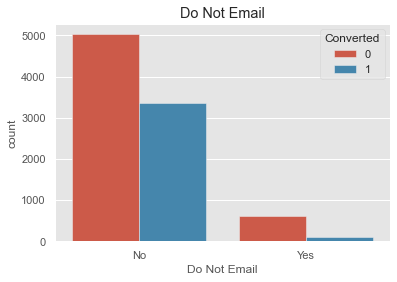

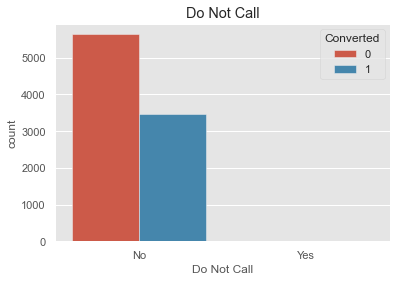

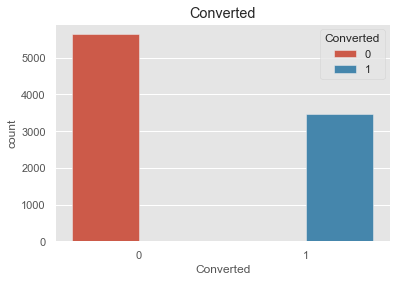

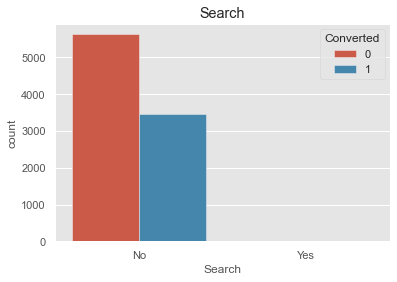

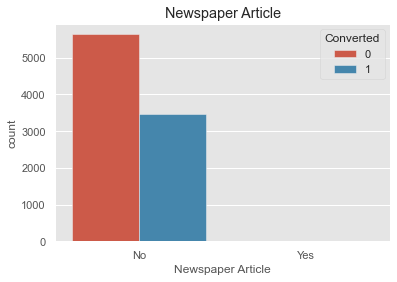

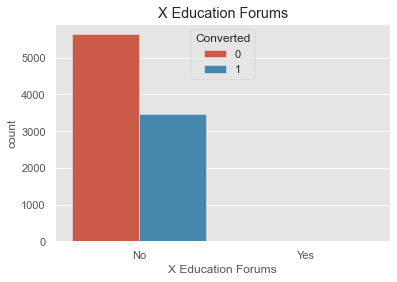

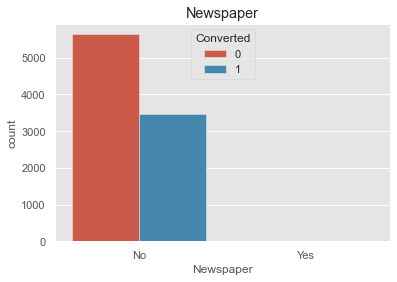

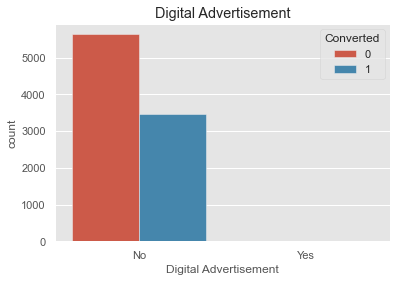

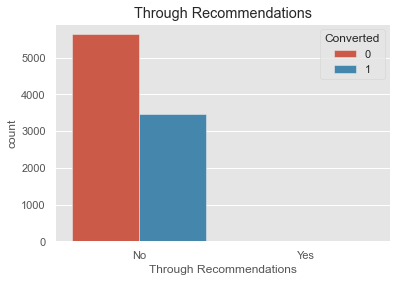

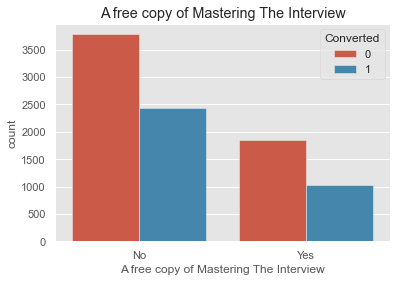

In [32]:
for i in bincol:
    sn.countplot(lead[i], hue= lead['Converted'])
    plt.title(i)
    plt.show()

As we can see columns-:  'Do Not Call','Search',
       'Newspaper Article', 'X Education Forums','Newspaper',
       'Digital Advertisement','Through Recommendations' do no have data for Yes sucategory- hence no varicance present in the columns. We will drop all these columns.

In [33]:
lead.drop(columns= [ 'Do Not Call','Search', 'Newspaper Article', 'X Education Forums','Newspaper', 'Digital Advertisement','Through Recommendations'], inplace=True)

## Numerical Feature Analysis

In [34]:
lead.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9103.000000,9103.000000,9103.000000,9103.000000
mean,0.380204,3.445238,481.350104,2.362820
std,0.485464,4.854853,545.066142,2.161418
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,9.000000,1.000000
50%,0.000000,3.000000,244.000000,2.000000
75%,1.000000,5.000000,919.500000,3.000000
max,1.000000,251.000000,2272.000000,55.000000


1. We can see there is a abrupt increase in TotalVisits columns from 75% data lyin around 5 and maxima at 251. That shows outlier presence. and need to be dealt with.
2. Same applies fro Total Time spent on Website where maxima is approx 2000 while 75% data lies around 900
3. Similar is the case for PAge Views Per visit
4. Converted column has an averae of 38% which means conversion rate is 38% only, that makes the dataset imbalance and may bias predictions if not handled

### TotalVisits

In [35]:
lead.TotalVisits.value_counts().head()

0.0    2189
2.0    1680
3.0    1306
4.0    1120
5.0     783
Name: TotalVisits, dtype: int64

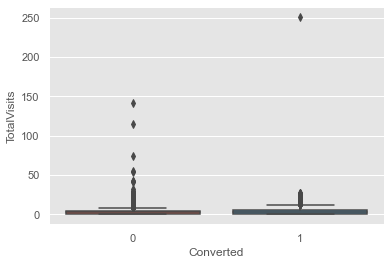

Total Converted entries:   0    9
1    1
Name: Converted, dtype: int64
99% Data lies in:   17.0


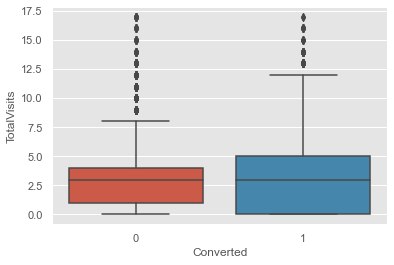

In [36]:
#Will convert totalvisits to int as we only ave 0 after decimal. Hence no data would be lost
lead['TotalVisits']= lead['TotalVisits'].astype(int)
sn.boxplot(data= lead, y= 'TotalVisits', x='Converted')
plt.show()

# As we can see outliers are present.
print('Total Converted entries:  ',lead[lead['TotalVisits']>30].Converted.value_counts())

# We only have 1 entry which got converted hence it won't harm dropping these rows. We'll check with quantiles before dropping.
print('99% Data lies in:  ',lead['TotalVisits'].quantile(0.99) )

# HEnce we'll drop the rows having >17 TotalVisits.
lead= lead[~(lead['TotalVisits']>17)]

sn.boxplot(data=lead, y= 'TotalVisits', x= 'Converted')
plt.show()

Higher distribution is present in converted class where Total visits varies from  0-5. This can account for the fact that customer is thinking of taking up the course and hence making sure if the investment would be right. These kind of people if talked through can be converted.

### Total Time Spent on Website

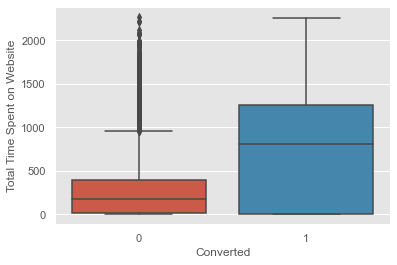

Total Converted entries:   1    13
0     7
Name: Converted, dtype: int64
99% Data lies in:   1836.619999999999


In [37]:
sn.boxplot(data= lead, y= 'Total Time Spent on Website', x='Converted')
plt.show()

# As we can see outliers are present but still they are in continuous fashion.
print('Total Converted entries:  ',lead[lead['Total Time Spent on Website']>2000].Converted.value_counts())

# We have higer entries for converted people here hence it won't  be a good idea to drop these rows. We'll check with quantiles before dropping.
print('99% Data lies in:  ',lead['Total Time Spent on Website'].quantile(0.99) )

# We will not be dropping aany of the rows from this column


This is related to TotalVisits analysis above- if totalVisits increase adn time spent on the website will also increase (generally). Hence we have higher distribution of converted people where time range is 0-1200. 

### Page Views Per Visit

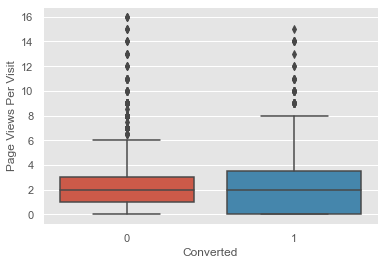

Total Converted entries:   0    6
1    1
Name: Converted, dtype: int64
99% Data lies in:   9.0


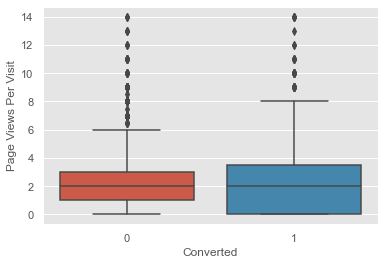

In [38]:
sn.boxplot(data= lead, y= 'Page Views Per Visit', x='Converted')
plt.show()

# As we can see outliers are present.
print('Total Converted entries:  ',lead[lead['Page Views Per Visit']>14].Converted.value_counts())

# We have higer entries for converted people here hence it won't  be a good idea to drop these rows. We'll check with quantiles before dropping.
print('99% Data lies in:  ',lead['Page Views Per Visit'].quantile(0.99) )

# Dropping the rows having more than 99% percentile data would cost us in terms of conversion rate as almost 30 conversion are present for these rows. 
# Hence we would not be dropping

# We can drop the ones greater than 14 (as seen from teh plot) as they don't have any converted people.
lead= lead[~(lead['Page Views Per Visit']>14)]

sn.boxplot(data= lead, y= 'Page Views Per Visit', x='Converted')
plt.show()

Median for both classes is almost same only, but distribution is higher for converted people in the same page views range. Many customer are present of converted class which ahve high pae visits, this means that they explore the website to find what all perks/demerits are there fro joining teh course. Application usability and content would play a important factor to engage more people. 

# Data Preprocessing

### One hot Encoding/ Ordinal Encoding for Categoical Features

In [39]:
lead.head()

,Prospect ID,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,API,Olark Chat,No,0,0,0,0.0,Page Visited on Website,Unemployed,Interested in other courses,Mumbai,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,API,Organic Search,No,0,5,674,2.5,Email Opened,Unemployed,Ringing,Mumbai,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,Landing Page Submission,Direct Traffic,No,1,2,1532,2.0,Email Opened,Student,Will revert after reading the email,Mumbai,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,Landing Page Submission,Direct Traffic,No,0,1,305,1.0,Other,Unemployed,Ringing,Mumbai,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,Landing Page Submission,Google,No,1,2,1428,1.0,Converted to Lead,Unemployed,Will revert after reading the email,Mumbai,No,Modified


Binary Columns

In [40]:
lead['Do Not Email']= lead['Do Not Email'].apply(lambda x: 1 if x=='Yes' else 0)
lead['A free copy of Mastering The Interview']= lead['A free copy of Mastering The Interview'].apply(lambda x: 1 if x=='Yes' else 0)

Categorical Columns- One Hot Encoding

In [41]:
lead.columns[lead.dtypes=='object']

Index(['Prospect ID', 'Lead Origin', 'Lead Source', 'Last Activity',
       'What is your current occupation', 'Tags', 'City',
       'Last Notable Activity'],
      dtype='object')

In [42]:
origin= pd.get_dummies(lead['Lead Origin'], prefix= 'origin')
source= pd.get_dummies(lead['Lead Source'], prefix= 'source')
occupation= pd.get_dummies(lead['What is your current occupation'], prefix= 'occupation')
last_acitvity= pd.get_dummies(lead['Last Activity'], prefix= 'last_acitvity')
tags= pd.get_dummies(lead['Tags'], prefix= 'tags')
city= pd.get_dummies(lead['City'], prefix= 'city')
last_notable_activity= pd.get_dummies(lead['Last Notable Activity'], prefix= 'last_notable_activity')


In [43]:
origin.drop(columns= ['origin_Lead Import'], inplace=True)
source.drop(columns= ['source_Other'], inplace=True)
occupation.drop(columns= ['occupation_Other'], inplace=True)
last_acitvity.drop(columns= ['last_acitvity_Converted to Lead'], inplace=True)
last_notable_activity.drop(columns= ['last_notable_activity_Other'], inplace=True)
tags.drop(columns= ['tags_Others'], inplace=True)
city.drop(columns= ['city_Tier II Cities'],inplace=True)

In [44]:
lead= pd.concat([lead, origin, source, occupation,last_acitvity,last_notable_activity,tags,city], axis= 1)
lead.drop(columns= ['Lead Origin', 'Lead Source','What is your current occupation','Last Activity', 'Last Notable Activity', 'Tags','City'], inplace=True)

In [45]:
lead.shape

(9013, 40)

In [46]:
lead.head()

,Prospect ID,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,origin_API,origin_Landing Page Submission,origin_Lead Add Form,source_Direct Traffic,source_Google,source_Olark Chat,source_Organic Search,source_Reference,occupation_Student,occupation_Unemployed,occupation_Unknown,occupation_Working Professional,last_acitvity_Email Opened,last_acitvity_Olark Chat Conversation,last_acitvity_Other,last_acitvity_Page Visited on Website,last_acitvity_SMS Sent,last_notable_activity_Email Opened,last_notable_activity_For sure Ones- Unreachable/PhoneConversation,last_notable_activity_Modified,last_notable_activity_SMS Sent,tags_Busy,tags_Closed by Horizzon,tags_Interested in other courses,tags_Lost to EINS,tags_Ringing,tags_Unknown,tags_Will revert after reading the email,city_Mumbai,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,2a272436-5132-4136-86fa-dcc88c88f482,0,0,5,674,2.5,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,0,1,2,1532,2.0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,0,0,1,305,1.0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,3256f628-e534-4826-9d63-4a8b88782852,0,1,2,1428,1.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0


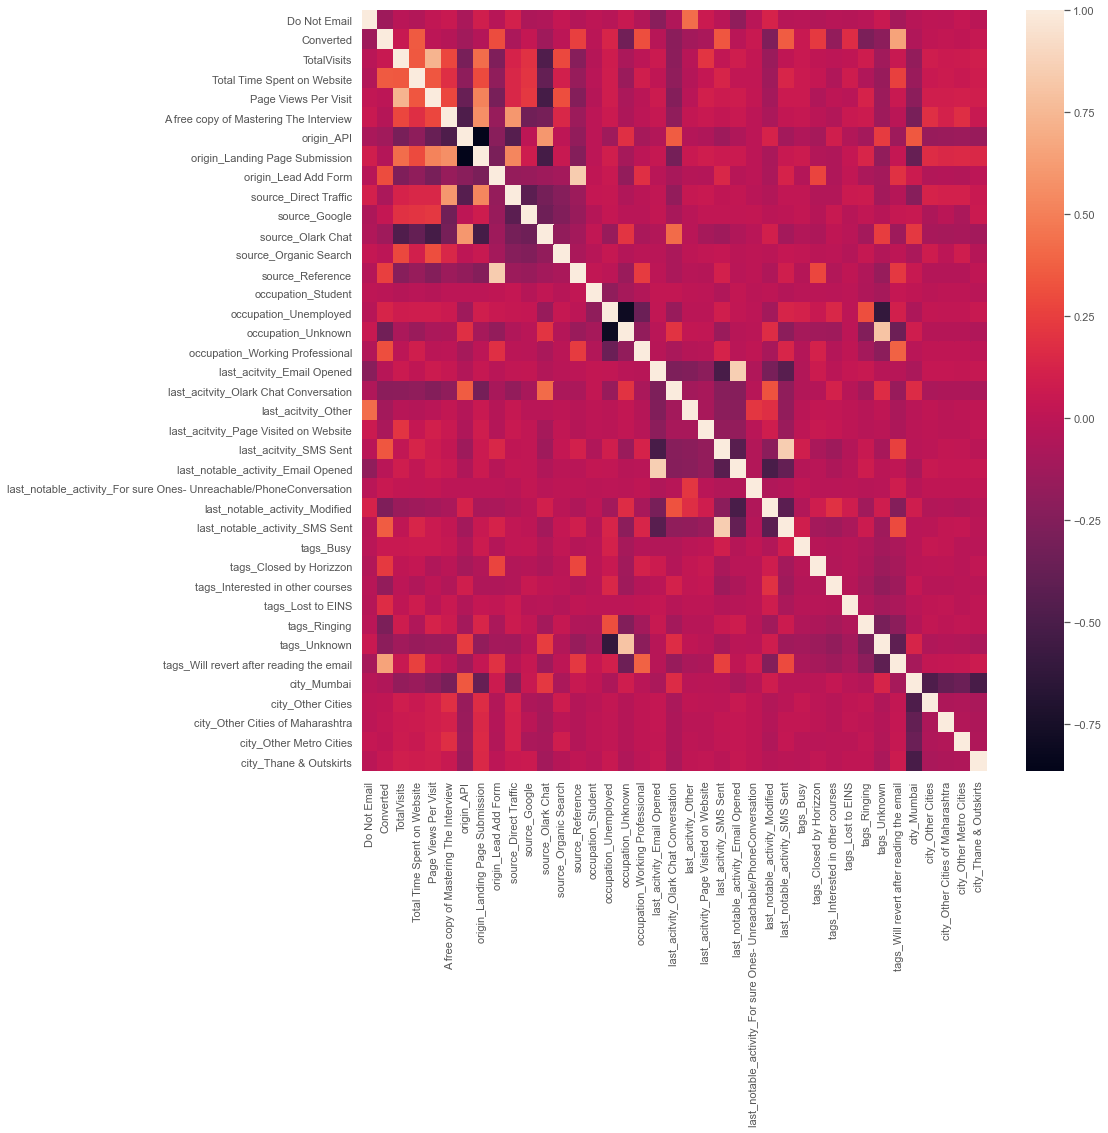

In [47]:
plt.figure(figsize= (14,14))
sn.heatmap(lead.corr())
plt.show()

Whole Dataset is in numerical form now

## Train- Test split and Scaling

Train-Test Split

In [48]:
train,test= train_test_split(lead, random_state=100, train_size=0.7)

In [49]:
backup_train=train.copy()
train.drop(columns= ['Prospect ID'], inplace=True)

backup_test=test.copy()
test.drop(columns= ['Prospect ID'], inplace=True)

backup_train= backup_train.reset_index(drop=True)
backup_test= backup_test.reset_index(drop=True)

In [50]:
print('Train Shape:  ', train.shape)
print('Test Shape:  ', test.shape)

Train Shape:   (6309, 39)
Test Shape:   (2704, 39)


In [51]:
# Conversion rates in both train & test
print('Train set Conversion rate:  ', train.Converted.mean())
print('Test set conversion rate:  ', test.Converted.mean())

# Almost equal in both sets

Train set Conversion rate:   0.3775558725630052
Test set conversion rate:   0.3853550295857988


In [52]:
train_y= train.pop('Converted')
train_y= train_y.reset_index(drop=True)
train_x= train.copy()

test_y= test.pop('Converted')
test_y= test_y.reset_index(drop=True)
test_x= test.copy()

In [53]:
train_x

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,origin_API,origin_Landing Page Submission,origin_Lead Add Form,source_Direct Traffic,source_Google,source_Olark Chat,source_Organic Search,source_Reference,occupation_Student,occupation_Unemployed,occupation_Unknown,occupation_Working Professional,last_acitvity_Email Opened,last_acitvity_Olark Chat Conversation,last_acitvity_Other,last_acitvity_Page Visited on Website,last_acitvity_SMS Sent,last_notable_activity_Email Opened,last_notable_activity_For sure Ones- Unreachable/PhoneConversation,last_notable_activity_Modified,last_notable_activity_SMS Sent,tags_Busy,tags_Closed by Horizzon,tags_Interested in other courses,tags_Lost to EINS,tags_Ringing,tags_Unknown,tags_Will revert after reading the email,city_Mumbai,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts
8344,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4937,0,3,234,3.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
5939,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
5685,0,6,504,6.0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
5370,1,2,171,2.0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0,4,1226,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
82,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8256,1,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
7122,1,1,258,1.0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


Scaling

In [54]:
scaler= MinMaxScaler()

In [55]:
train_scaled= scaler.fit_transform(train_x)
test_scaled= scaler.transform(test_x)

In [56]:
train_scaled= pd.DataFrame(train_scaled, columns= train_x.columns)
test_scaled= pd.DataFrame(test_scaled, columns=test_x.columns)

# Modelling

Performing weighted Logistic Regression because of imbalanced data. Will use weight as the ratio of conversion rate present ie, 0.38.

## Model 1

In [57]:
weight= {0:38, 1:100}
lrm= LogisticRegression(random_state= 15, class_weight= weight)
lrm.fit(train_scaled,train_y)

train_y_pred= lrm.predict(train_scaled)
train_y_pred

accu= metrics.accuracy_score(train_y, train_y_pred)
conf=metrics.confusion_matrix(train_y,train_y_pred)
sens= conf[1][1]/ float(conf[1][1]+ conf[1][0])
spec= conf[0][0]/ float(conf[0][0]+ conf[0][1]) 
auc= metrics.roc_auc_score(train_y, train_y_pred)
f1= metrics.f1_score(train_y, train_y_pred)
print("accuracy: {0}  sensitivity: {1}  specificity: {2}  auc: {3}  f1: {4}".format(accu, sens, spec,auc, f1))

accuracy: 0.9310508796956728  sensitivity: 0.9433249370277078  specificity: 0.9236058059587471  auc: 0.9334653714932275  f1: 0.9117468046256847


For 1st model all the evaluation metrics looks a lot good. We'll check for feature importance to modify our model and check for overfitting

## Feature Importance using Random Forest

In [58]:
rfm= RandomForestClassifier()
rfm.fit(train_scaled,train_y)
importance=rfm.feature_importances_
l= list(zip(train_scaled.columns, importance))
l

[('Do Not Email', 0.007617365793350476),
 ('TotalVisits', 0.031808224203160713),
 ('Total Time Spent on Website', 0.15422589195326458),
 ('Page Views Per Visit', 0.0307228196261423),
 ('A free copy of Mastering The Interview', 0.006413336280750116),
 ('origin_API', 0.00760095032534259),
 ('origin_Landing Page Submission', 0.006978653392560558),
 ('origin_Lead Add Form', 0.0389957591164834),
 ('source_Direct Traffic', 0.005738546574391747),
 ('source_Google', 0.00591532054230155),
 ('source_Olark Chat', 0.004590270069781646),
 ('source_Organic Search', 0.004510706301065147),
 ('source_Reference', 0.01224588523402529),
 ('occupation_Student', 0.0016210074958333375),
 ('occupation_Unemployed', 0.016459499101585916),
 ('occupation_Unknown', 0.03271308898319073),
 ('occupation_Working Professional', 0.024848248974867305),
 ('last_acitvity_Email Opened', 0.006161699338382996),
 ('last_acitvity_Olark Chat Conversation', 0.004381351527227487),
 ('last_acitvity_Other', 0.0030760947598012785),
 

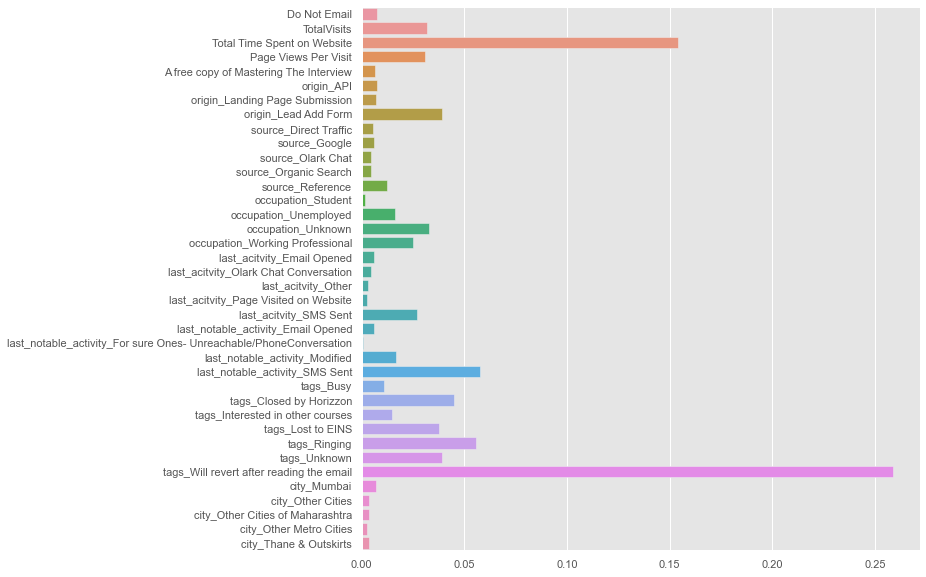

In [59]:
plt.figure(figsize= (10,10))
sn.barplot(y=train_scaled.columns, x=importance)
plt.show()

'TotalVisits', 'Total Time Spent on Website','Page Views Per Visit', 'origin_Lead Add Form', 
'occupation_Unknown',  'last_acitvity_SMS Sent','last_notable_activity_SMS Sent',   'tags_Closed by Horizzon', 'tags_Lost to EINS', 'tags_Ringing','tags_Unknown', 'tags_Will revert after reading the email','occupation__Working Professional' ----Important Columns

In [60]:
train_scaled.columns

Index(['Do Not Email', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'A free copy of Mastering The Interview',
       'origin_API', 'origin_Landing Page Submission', 'origin_Lead Add Form',
       'source_Direct Traffic', 'source_Google', 'source_Olark Chat',
       'source_Organic Search', 'source_Reference', 'occupation_Student',
       'occupation_Unemployed', 'occupation_Unknown',
       'occupation_Working Professional', 'last_acitvity_Email Opened',
       'last_acitvity_Olark Chat Conversation', 'last_acitvity_Other',
       'last_acitvity_Page Visited on Website', 'last_acitvity_SMS Sent',
       'last_notable_activity_Email Opened',
       'last_notable_activity_For sure Ones- Unreachable/PhoneConversation',
       'last_notable_activity_Modified', 'last_notable_activity_SMS Sent',
       'tags_Busy', 'tags_Closed by Horizzon',
       'tags_Interested in other courses', 'tags_Lost to EINS', 'tags_Ringing',
       'tags_Unknown', 'tags_Will revert

In [61]:
backp= train_scaled.copy()

In [62]:
# Extraction of most important columns
train_scaled= train_scaled[['tags_Will revert after reading the email','tags_Lost to EINS', 'tags_Ringing',
       'tags_Unknown','tags_Closed by Horizzon','last_notable_activity_SMS Sent','last_acitvity_SMS Sent','occupation_Working Professional',
    'occupation_Unknown', 'origin_Lead Add Form','TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit'
    ]]

## Model 2

### Weighted logistic Regression using sklearn

In [63]:
weight= {0:38, 1:100}
lrm= LogisticRegression(random_state= 15, class_weight= weight)
lrm.fit(train_scaled,train_y)

train_y_pred= lrm.predict(train_scaled)
train_y_pred

accu= metrics.accuracy_score(train_y, train_y_pred)
conf=metrics.confusion_matrix(train_y,train_y_pred)
sens= conf[1][1]/ float(conf[1][1]+ conf[1][0])
spec= conf[0][0]/ float(conf[0][0]+ conf[0][1]) 
auc= metrics.roc_auc_score(train_y, train_y_pred)
f1= metrics.f1_score(train_y, train_y_pred)
print("accuracy: {0}  sensitivity: {1}  specificity: {2}  auc: {3}  f1: {4}".format(accu, sens, spec,auc, f1))

accuracy: 0.9182120779838326  sensitivity: 0.9315701091519731  specificity: 0.9101094983447925  auc: 0.9208398037483828  f1: 0.895841744045216


In [64]:
train_scaled.shape

(6309, 13)

In [65]:
vif=pd.DataFrame()
vif['Features']= train_scaled.columns
vif['VIF']= [variance_inflation_factor(train_scaled.values,i)  for i in range(train_scaled.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif

,Features,VIF
0,tags_Will revert after reading the email,2.20
1,tags_Lost to EINS,1.10
2,tags_Ringing,1.30
3,tags_Unknown,4.94
4,tags_Closed by Horizzon,1.26
5,last_notable_activity_SMS Sent,5.11
6,last_acitvity_SMS Sent,5.31
7,occupation_Working Professional,1.34
8,occupation_Unknown,4.44
9,origin_Lead Add Form,1.42


### Weighted Logistic Regression using GLM

In [66]:
weights= train_y
weights= [100 if i==1 else 38 for i in weights]
weights
glm= sm.GLM(train_y,sm.add_constant(train_scaled),family=sm.families.Binomial(), freq_weights= weights).fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6309
Model:                            GLM   Df Residuals:                   387412
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77933.
Date:                Tue, 07 Sep 2021   Deviance:                   1.5587e+05
Time:                        13:39:47   Pearson chi2:                 6.33e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.4025      0.019   -178.379      0.000      -3.440      -3.365
tags_Will revert after reading the email     6.1960      0.032    191.359      0.000       6.133       6.260
tags_Lost to EINS                            8.5693      0.100     86.071      0.000       8.374       8.764
tags_Ringing                                -1.7447      0.028    -61.470      0.000      -1.800      -1.689
tags_Unknown                                 3.6881      0.022    164.536      0.000       3.644       3.732
tags_Closed by Horizzon                      8.2284      0.164     50.221      0.000       7.907       8.549
last_notable_activity_SMS Sent               1.5552      0.025     62.690      0.000       1.507       1.604
last_acitvity_SMS Sent                       1.2057      0.023     52.912      0.000       1.161       1.250
occupation_Working Professional              0.0427      0.048      0.884      0.377      -0.052       0.137
occupation_Unknown                          -2.8285      0.020   -142.660      0.000      -2.867      -2.790
origin_Lead Add Form                         1.8052      0.045     40.326      0.000       1.717       1.893
TotalVisits                                  0.5814      0.058     10.017      0.000       0.468       0.695
Total Time Spent on Website                  3.8637      0.030    129.801      0.000       3.805       3.922
Page Views Per Visit                        -1.3465      0.069    -19.643      0.000      -1.481      -1.212
============================================================================================================
"""

Working Professional seems insignificant. Will be dropping it.

## Model 3

In [67]:
backp= train_scaled.copy()
train_scaled.drop(columns= ['occupation_Working Professional'], inplace=True)
train_scaled_c=sm.add_constant(train_scaled)
glm= sm.GLM(train_y,train_scaled_c,family=sm.families.Binomial(),freq_weights= weights).fit()
print(glm.summary())

vif=pd.DataFrame()
vif['Features']= train_scaled.columns
vif['VIF']= [variance_inflation_factor(train_scaled.values,i)  for i in range(train_scaled.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6309
Model:                            GLM   Df Residuals:                   387413
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77933.
Date:                Tue, 07 Sep 2021   Deviance:                   1.5587e+05
Time:                        13:39:47   Pearson chi2:                 6.35e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

,Features,VIF
0,tags_Will revert after reading the email,1.95
1,tags_Lost to EINS,1.10
2,tags_Ringing,1.30
3,tags_Unknown,4.94
4,tags_Closed by Horizzon,1.24
5,last_notable_activity_SMS Sent,5.10
6,last_acitvity_SMS Sent,5.31
7,occupation_Unknown,4.44
8,origin_Lead Add Form,1.42
9,TotalVisits,4.80


Dropping last_acitvity_SMS Sent

## Model 4

In [68]:
train_scaled.drop(columns=['last_acitvity_SMS Sent'],inplace=True)
train_scaled_c= sm.add_constant(train_scaled)
# train_scaled_c.drop(columns=['Page Views Per Visit'],inplace=True)
#train_scaled.drop(columns=['TotalVisits'],inplace=True)

glm= sm.GLM(train_y,train_scaled_c,family=sm.families.Binomial(),freq_weights= weights).fit()
print(glm.summary())

vif=pd.DataFrame()
vif['Features']= train_scaled.columns
vif['VIF']= [variance_inflation_factor(train_scaled.values,i)  for i in range(train_scaled.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6309
Model:                            GLM   Df Residuals:                   387414
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79260.
Date:                Tue, 07 Sep 2021   Deviance:                   1.5852e+05
Time:                        13:39:47   Pearson chi2:                 5.25e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

,Features,VIF
0,tags_Will revert after reading the email,1.95
1,tags_Lost to EINS,1.09
2,tags_Ringing,1.30
3,tags_Unknown,4.94
4,tags_Closed by Horizzon,1.24
5,last_notable_activity_SMS Sent,1.53
6,occupation_Unknown,4.43
7,origin_Lead Add Form,1.41
8,TotalVisits,4.80
9,Total Time Spent on Website,2.31


Dropping total Visits

# Model 5

In [69]:
train_scaled.drop(columns=['TotalVisits'],inplace=True)
train_scaled_c= sm.add_constant(train_scaled)
# train_scaled_c.drop(columns=['Page Views Per Visit'],inplace=True)


glm= sm.GLM(train_y,train_scaled_c,family=sm.families.Binomial(),freq_weights= weights).fit()
print(glm.summary())

vif=pd.DataFrame()
vif['Features']= train_scaled.columns
vif['VIF']= [variance_inflation_factor(train_scaled.values,i)  for i in range(train_scaled.shape[1])]
vif['VIF']= round(vif['VIF'],2)
vif

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6309
Model:                            GLM   Df Residuals:                   387415
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79312.
Date:                Tue, 07 Sep 2021   Deviance:                   1.5862e+05
Time:                        13:39:47   Pearson chi2:                 5.24e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

,Features,VIF
0,tags_Will revert after reading the email,1.93
1,tags_Lost to EINS,1.09
2,tags_Ringing,1.29
3,tags_Unknown,4.91
4,tags_Closed by Horizzon,1.22
5,last_notable_activity_SMS Sent,1.53
6,occupation_Unknown,4.43
7,origin_Lead Add Form,1.40
8,Total Time Spent on Website,2.26
9,Page Views Per Visit,2.31


## Note
#### We can drop unknown occupation and unknown tags column as it doesn't  convey any business justification, hence on business request we can drop those . Although for  now we are not dropping these as they are increasing the model accuracy by 2%.

#### We can finalize this model as it seems statistically valid in terms of VIF and Pvalues. Also we used weighted loistic regression to deal with data imbalance by statin the freq_weights in GLM. 

In [70]:
# train_scaled.drop(columns=['occupation_Unknown'],inplace=True)
# train_scaled_c= sm.add_constant(train_scaled)

# glm= sm.GLM(train_y,train_scaled_c,family=sm.families.Binomial(),freq_weights= weights).fit()
# print(glm.summary())

# vif=pd.DataFrame()
# vif['Features']= train_scaled.columns
# vif['VIF']= [variance_inflation_factor(train_scaled.values,i)  for i in range(train_scaled.shape[1])]
# vif['VIF']= round(vif['VIF'],2)
# vif

In [71]:
# train_scaled.drop(columns=['tags_Unknown'],inplace=True)
# train_scaled_c= sm.add_constant(train_scaled)

# weight= {0:38, 1:100}

# glm= sm.GLM(train_y,train_scaled_c,family=sm.families.Binomial(),freq_weights= weights).fit()
# print(glm.summary())

# vif=pd.DataFrame()
# vif['Features']= train_scaled.columns
# vif['VIF']= [variance_inflation_factor(train_scaled.values,i)  for i in range(train_scaled.shape[1])]
# vif['VIF']= round(vif['VIF'],2)
# vif

In [72]:
train_y_pred_glm= glm.predict(train_scaled_c)
final_train= pd.DataFrame()
final_train['Prospect ID']= backup_train['Prospect ID']
final_train['Probability']= train_y_pred_glm
l= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in l:
    final_train[i]= final_train['Probability'].apply(lambda x: 1 if x>i else 0)
final_train['Converted']= train_y
final_train


,Prospect ID,Probability,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Converted
0,aa5fb614-bf24-408d-9c89-e97b91d9479d,0.087253,0,0,0,0,0,0,0,0,0,0
1,413fb82a-0eaa-4e44-a0f1-07276f790d4f,0.103020,1,0,0,0,0,0,0,0,0,0
2,bb35e17e-2768-4083-b537-9793b3df6b7b,0.087253,0,0,0,0,0,0,0,0,0,0
3,ac96d81a-c83e-45ce-8417-1c1ca7a52ef5,0.997504,1,1,1,1,1,1,1,1,1,1
4,0ed18e6a-a8ec-4c3d-a9fb-81f355d6a8aa,0.382309,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6304,ea8cff4f-7ddb-4d66-bb10-8b71027539ef,0.991663,1,1,1,1,1,1,1,1,1,1
6305,a9b219c8-a9c2-4d13-9a4d-46cfe4f70eeb,0.946389,1,1,1,1,1,1,1,1,1,1
6306,2c35df5d-465f-444d-9815-898303655713,0.087253,0,0,0,0,0,0,0,0,0,0
6307,51a4fa01-a13d-4ae4-aa6c-3c82a496ec31,0.054373,0,0,0,0,0,0,0,0,0,0


In [73]:
metric_table= pd.DataFrame(columns= ['Cutoff', 'Accuracy', 'Sensitivity', 'Specificity', 'AUC_Score', 'F1_Score'])
for i in l:
    conf= metrics.confusion_matrix(train_y, final_train[i])
    acc= metrics.accuracy_score(train_y, final_train[i])
    sens= conf[1][1]/ float(conf[1][1]+conf[1][0])
    spec= conf[0][0]/ float(conf[0][0]+conf[0][1])
    auc= metrics.roc_auc_score(train_y,final_train[i])
    f1= metrics.f1_score(train_y,final_train[i])
    metric_table.loc[i]= [i,acc,sens,spec,auc,f1]
metric_table

,Cutoff,Accuracy,Sensitivity,Specificity,AUC_Score,F1_Score
0.1,0.1,0.771913,0.978170,0.646804,0.812487,0.764060
0.2,0.2,0.866223,0.963056,0.807487,0.885271,0.844624
0.3,0.3,0.881756,0.955500,0.837026,0.896263,0.859192
0.4,0.4,0.903630,0.939547,0.881844,0.910695,0.880409
0.5,0.5,0.916310,0.927372,0.909600,0.918486,0.893247
0.6,0.6,0.926454,0.890008,0.948561,0.919285,0.901361
0.7,0.7,0.933111,0.878673,0.966132,0.922403,0.908420
0.8,0.8,0.932794,0.862720,0.975299,0.919010,0.906484
0.9,0.9,0.922650,0.825777,0.981411,0.903594,0.889643


We 'll take cutoff at 0.5

In [86]:
final_train['Predicted']= final_train['Probability'].apply(lambda x: 1 if x>0.5 else 0)
final_train.drop(columns= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], inplace=True)
final_train['Lead Score']= round((final_train['Probability'] * 100),2)
final_train['Status']= final_train['Lead Score'].apply(lambda x: 'Hot' if x>50 else 'Cold' )

In [87]:
final_train

,Prospect ID,Probability,Converted,Predicted,Lead Score,Status
0,aa5fb614-bf24-408d-9c89-e97b91d9479d,0.087253,0,0,8.73,Cold
1,413fb82a-0eaa-4e44-a0f1-07276f790d4f,0.103020,0,0,10.30,Cold
2,bb35e17e-2768-4083-b537-9793b3df6b7b,0.087253,0,0,8.73,Cold
3,ac96d81a-c83e-45ce-8417-1c1ca7a52ef5,0.997504,1,1,99.75,Hot
4,0ed18e6a-a8ec-4c3d-a9fb-81f355d6a8aa,0.382309,0,0,38.23,Cold
...,...,...,...,...,...,...
6304,ea8cff4f-7ddb-4d66-bb10-8b71027539ef,0.991663,1,1,99.17,Hot
6305,a9b219c8-a9c2-4d13-9a4d-46cfe4f70eeb,0.946389,1,1,94.64,Hot
6306,2c35df5d-465f-444d-9815-898303655713,0.087253,0,0,8.73,Cold
6307,51a4fa01-a13d-4ae4-aa6c-3c82a496ec31,0.054373,0,0,5.44,Cold


In [76]:
accu= metrics.accuracy_score(train_y, final_train.Predicted)
conf=metrics.confusion_matrix(train_y,final_train.Predicted)
sens= conf[1][1]/ float(conf[1][1]+ conf[1][0])
spec= conf[0][0]/ float(conf[0][0]+ conf[0][1]) 
auc= metrics.roc_auc_score(train_y, final_train.Predicted)
f1= metrics.f1_score(train_y, final_train.Predicted)
print("accuracy: {0}  sensitivity: {1}  specificity: {2}  auc: {3}  f1: {4}".format(round(accu,2), round(sens,2), round(spec,2),round(auc,2), round(f1,2)))

accuracy: 0.92  sensitivity: 0.93  specificity: 0.91  auc: 0.92  f1: 0.89


[0.        0.0903998 1.       ] [0.         0.92737196 1.        ] [2 1 0]


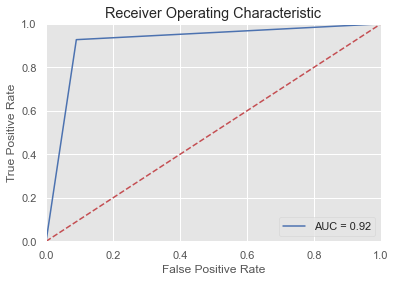

In [77]:
fpr,tpr,threshold= metrics.roc_curve(train_y,final_train.Predicted)
roc_auc = metrics.auc(fpr, tpr)
print(fpr, tpr, threshold)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Test Set Predictions

In [78]:
l= train_scaled.columns
l

Index(['tags_Will revert after reading the email', 'tags_Lost to EINS',
       'tags_Ringing', 'tags_Unknown', 'tags_Closed by Horizzon',
       'last_notable_activity_SMS Sent', 'occupation_Unknown',
       'origin_Lead Add Form', 'Total Time Spent on Website',
       'Page Views Per Visit'],
      dtype='object')

In [82]:
test_scaled= test_scaled[['tags_Will revert after reading the email', 'tags_Lost to EINS',
       'tags_Ringing', 'tags_Unknown', 'tags_Closed by Horizzon',
       'last_notable_activity_SMS Sent', 'occupation_Unknown',
       'origin_Lead Add Form', 'Total Time Spent on Website',
       'Page Views Per Visit']]

In [89]:
test_y_pred_glm= glm.predict(sm.add_constant(test_scaled))
final_test= pd.DataFrame()
final_test['Prospect ID']= backup_test['Prospect ID']
final_test['Probability']= test_y_pred_glm
final_test['Converted']= test_y
final_test['Predicted']= final_test['Probability'].apply(lambda x: 1 if x>0.5 else 0)
final_test['Lead Score']= round((final_test['Probability'] * 100),2)
final_test['Status']= final_test['Lead Score'].apply(lambda x: 'Hot' if x>50 else 'Cold' )
final_test

,Prospect ID,Probability,Converted,Predicted,Lead Score,Status
0,0236de11-bd6d-42c0-8205-1bf00c15a61a,0.037385,0,0,3.74,Cold
1,f50f98db-9c40-449f-9673-903a7b5d05b5,0.995562,1,1,99.56,Hot
2,f2b235a1-6a92-445b-9b13-f24469e13878,0.037385,0,0,3.74,Cold
3,07b30963-4872-439f-b141-a8b51520bd32,0.063233,0,0,6.32,Cold
4,b9311434-ff02-4100-a773-2f5bd5687067,0.037168,0,0,3.72,Cold
...,...,...,...,...,...,...
2699,62beb7b0-d7d0-4678-9996-a4c58ec3b69d,0.037385,0,0,3.74,Cold
2700,a5603fdd-8283-4432-9a8b-cc6ab1e0b8cd,0.364514,1,0,36.45,Cold
2701,49b534c4-1de2-4618-bce9-c4ed34ab6c6c,0.878390,1,1,87.84,Hot
2702,10cb3520-b834-4a6e-8e1f-14687f7e757c,0.047185,0,0,4.72,Cold


In [92]:
accu= metrics.accuracy_score(test_y, final_test.Predicted)
conf=metrics.confusion_matrix(test_y,final_test.Predicted)
sens= conf[1][1]/ float(conf[1][1]+ conf[1][0])
spec= conf[0][0]/ float(conf[0][0]+ conf[0][1]) 
auc= metrics.roc_auc_score(test_y, final_test.Predicted)
f1= metrics.f1_score(test_y, final_test.Predicted)
print("accuracy: {0}  sensitivity: {1}  specificity: {2}  auc: {3}  f1: {4}".format(round(accu,2), round(sens,2), round(spec,2),round(auc,2), round(f1,2)))

accuracy: 0.91  sensitivity: 0.93  specificity: 0.91  auc: 0.92  f1: 0.89


# Observation

1. Model's Evalations Metrics are coming as follows:
accuracy: 0.91
sensitivity: 0.93 
specificity: 0.91 
auc: 0.92  
f1: 0.89

Model seems to predict 93% of the data correctly.

2.Predictior Variables:

    tags_Will revert after reading the email,
    tags_Lost to EINS,
    tags_Ringing ,
    tags_Closed by Horizzon,
    last_notable_activity_SMS Sent, 
    origin_Lead Add Form, 
    Total Time Spent on Website,
    Page Views Per Visit,
    tags_Unknown
    occupation_Unknown
3. Out of all these variables tags_Will revert after reading the email, tags_Lost to EINS,tags_Closed by Horizzon have highest coeffiecients and hence impact the predictibility power a lot. Hence not dropping the Tags variable was a right decision.


4. Company shold focus on below  features 

    a.The customers who have a current status (Tags) as "Will revert after reading the email", "Lost to EINS","Closed by Horizzon" are most likely to convert and buying the course. 
    b. Total Time spent on Website is another feature which has a lot of impact on converting a lead. So if a customer is putting effort in exploring the whole website, they can be enticed by either sending mails/phone calls, this would result in higher conversion rates
    c. Customers who have lead origin as Lead Add Form are also more likely to be converted.
 
 5. One thing to note is tags_Unknown and occupation_Unknown impact the model significantly, hence just leaving out the customers who have not filled in any of the above categories doesn't mean that they are a less likely candidate. For these type of customers we can closely monitor other features like Total time spent on website/ page views/last_notable_activity and accordingly should take action. 
    